# How to Directly Access OCO-2 Data from an S3 Bucket with Python
### Author: Jon Hobbs, Alexis Hunzinger
### Date Authored: 6-10-25

### Timing

Exercise: 15 minutes

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?keywords=%22earthdata%20cloud%22&amp;title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

### Overview

This notebook provides a quick demonstration on accessing and summarizing products from the Orbiting Carbon Observatory-2 (OCO-2) hosted via an Amazon S3 bucket. It demonstrates how to access an S3 bucket with the S3FS library, how to read data with xarray, and how to quickly compute and plot small-area aggregate estimates of atmospheric carbon dioxide.

Additional resources for identifying S3 URLs for NASA datasets and for accessing them can be found in the GES DISC cloud tutorials and documentation for the earthaccess Python library.

* [Obtain a List of S3 URLs](https://github.com/nasa/gesdisc-tutorials/blob/main/cloud-tutorials/notebooks/How_to_Obtain_a_List_of_S3_URLs_for_GES_DISC_Collection_Using_Python.ipynb)
* [Accessing MERRA-2 from S3 Bucket](https://github.com/nasa/gesdisc-tutorials/blob/main/cloud-tutorials/notebooks/How_to_Directly_Access_MERRA-2_Data_from_an_S3_Bucket.ipynb)
* [README for earthaccess Python library](https://github.com/nsidc/earthaccess)

## Import libraries

In [31]:
import earthaccess
import xarray as xr
import pandas as pd
import numpy as np

import boto3
import warnings
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
%matplotlib inline

## AWS Region Check

A common error when executing this notebook occurs when the notebook is run outside of the us-west-2 AWS region. An error message is displayed if outside of the AWS us-west-2 region. 

*This cell is not necessary to access the S3 buckets for users inside the us-west-2 region, and can be commented out or deleted at the users' discretion.*

In [13]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

### us-west-2 Region Check: &#x2705;

## Authentication

Access to NASA data requires NASA Earthdata authentication. We recommend authenticating your Earthdata Login (EDL) information using the `earthaccess` library as follows:

In [16]:
auth = earthaccess.login(strategy="netrc") # works if the EDL login already been persisted to a netrc
if not auth.authenticated:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

## Search 

### Search for OCO-2 products in the CMR catalog using `earthaccess`

Request the desired OCO-2 products for specified date range and product version. Here the search is by the product's short name. The [OCO-2 "lite" CO2 product](https://doi.org/10.5067/8E4VLCK16O6Q) is used for this analysis. 

In [10]:
short_name = 'OCO2_L2_Lite_FP'
version = '11.1r'
start_time = '2020-07-05'
end_time = '2020-07-07'

results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    cloud_hosted=True,
    temporal=(start_time,end_time)
)

### Obtain S3 URLs for found granules, then aggregate

In [18]:
s3_urls = [granule.data_links(access="direct")[0] for granule in results]
s3_urls

['s3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200704_B11100Ar_230603215457s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200705_B11100Ar_230603215543s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200706_B11100Ar_230603215547s.nc4',
 's3://gesdisc-cumulus-prod-protected/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2020/oco2_LtCO2_200707_B11100Ar_230603215704s.nc4']

## Open granules using `earthaccess` and `xarray`

In [23]:
file_handlers = earthaccess.open(results)
ds = xr.open_dataset(file_handlers[0], decode_coords="all")

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
sdg = ds.sounding_id.values[:]
lat = ds.latitude.values[:]
lon = ds.longitude.values[:]
xco2 = ds.xco2.values[:]
flg = ds.xco2_quality_flag[:]

dfr = pd.DataFrame({'SoundingID': sdg, 
                          'Latitude': lat, 'Longitude': lon, 'XCO2': xco2, 'V11QFlag': flg})
dfr['Sdg10s'] = np.floor(dfr['SoundingID'] / 1.0e3)
dfr = dfr[dfr['V11QFlag'] == 0]

In [30]:
dfr

,SoundingID,Latitude,Longitude,XCO2,V11QFlag,Sdg10s
34,2.020070e+15,-38.344372,-152.270706,411.636200,0.0,2.020070e+12
68,2.020070e+15,-36.668865,-152.755554,412.651978,0.0,2.020070e+12
92,2.020070e+15,-34.615337,-153.267776,410.651947,0.0,2.020070e+12
93,2.020070e+15,-34.608753,-153.290451,410.464233,0.0,2.020070e+12
100,2.020070e+15,-34.598209,-153.208237,411.708344,0.0,2.020070e+12
...,...,...,...,...,...,...
158269,2.020070e+15,78.992409,97.174576,412.261169,0.0,2.020070e+12
158271,2.020070e+15,79.022301,97.301666,413.505554,0.0,2.020070e+12
158274,2.020070e+15,78.985771,97.089539,410.017120,0.0,2.020070e+12
158282,2.020070e+15,79.002426,97.048065,410.701630,0.0,2.020070e+12


In [32]:
### Group and summarize

In [ ]:
def qsummary(df,grpvr,vrlst):
    # Summarize with quantiles
    nmtch = df.shape[0] 
    dfout = pd.DataFrame({'NSmp' : nmtch}, index=[0])
    #dfout[grpvr] = df[grpvr].values[0]
    for j in range(len(vrlst)):
        tmpdt = df[vrlst[j]]
        dtvld = tmpdt[np.isfinite(tmpdt)]
        dtvld = dtvld[dtvld != 0.0]
        vrnm = '%s_Med' % (vrlst[j])
        dfout[vrnm] = np.median(dtvld)

    return dfout

In [34]:
grpoco = dfr.groupby(['Sdg10s'])
ocoqs = grpoco.apply(qsummary,grpvr='Sdg10s',vrlst=['XCO2','Latitude','Longitude'])#,include_groups=False)
ocoqs.reset_index(drop=False,inplace=True)

In [35]:
ocoqs = ocoqs[ocoqs['NSmp'] > 30]

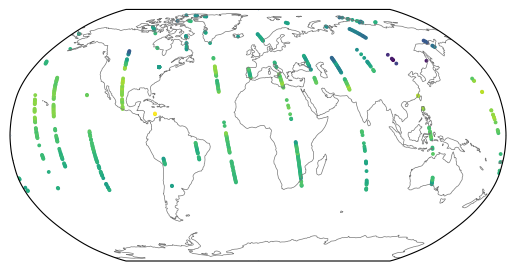

In [36]:
# Plotting, mapping libraries

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline
trnsfrm = ccrs.PlateCarree()

# Set up figure
fig = plt.figure()

pmp = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
cs = plt.scatter(ocoqs['Longitude_Med'],ocoqs['Latitude_Med'],s=3, c=ocoqs['XCO2_Med'], transform = trnsfrm)
#cs = pyplot.pcolormesh(lnarr,ltarr,ctarr[j,:,:],vmin=0,vmax=6000,transform = trnsfrm,cmap=cmpvic)
pmp.coastlines(color='#777777',linewidth=0.5)
pmp.scatter([-180,180,0,0],[0,0,-90,90],s=0.01,c=None,transform=trnsfrm)
plt.show()